In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import platform
import pathlib  
import os.path
import datetime
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from matplotlib.animation import FuncAnimation
from pathlib import Path
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import tempfile

In [2]:
# If errors occur here please refer to the readme file or to the file_imports.py folders. 

cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
root = src.parent
OS_type = platform.system()
sys.path.append(str(src))
sys.path.append(str(root))
from utils.file_imports import *

# Load in the precipitation data that is located in the GIT folder itself
path_data_folder = Path(r"../data/3_precip")
file_path = path_data_folder.joinpath(r"chirps_2018_2022_28.45_43.55_-5.05_5.45.nc")

print(f"Precipitation data will be loaded from the {path_precip} folder")

data_paths = file_paths(root, TAHMO = True, catchments = True)
raw_files = data_paths[0]
processed_files = data_paths[1]
shapefiles = data_paths[-2]

Precipitation data will be loaded from the ../data/3_precip/chirps_2018_2022_28.45_43.55_-5.05_5.45.nc folder
The first entry is pointing to /Users/matskerver/Documents/data_tana/TAHMO/raw_TAHMO, the second one to /Users/matskerver/Documents/data_tana/TAHMO/processed_TAHMO and the third one to /Users/matskerver/Documents/data_tana/TAHMO/interpolated_TAHMO. Animations will be located in /Users/matskerver/Documents/data_tana/TAHMO/results


In [3]:
# Open the Chirps dataset and assign correct coordinates 
datasets = {}

file_name = os.path.basename(file_path)  
file_identifier = file_name.split('_')[0]  
dataset = xr.open_dataset(file_path)
dataset = dataset.assign_coords(file_identifier=file_identifier)
datasets[file_identifier] = dataset
chirps_file = dataset
chirps = datasets['chirps']

In [ ]:
# loading station data from a specific TAHMO station

station = os.path.join(processed_files, 'location_data_TA00023.csv')

df_loc = pd.read_csv(station, index_col = 0, sep =',', parse_dates = True)
lon = df_loc['longitude'].iloc[0]
lat = df_loc['latitude'].iloc[0]

chirps_file = chirps
station_file = df_loc

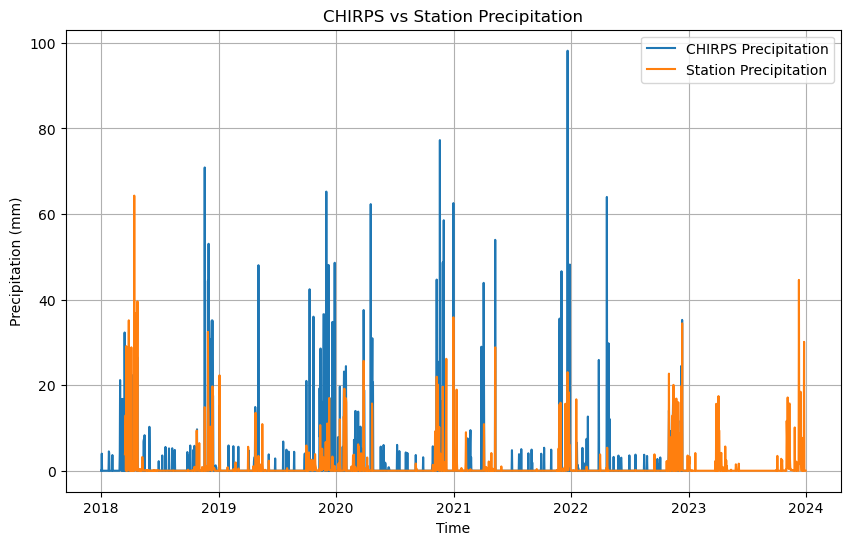

Correlation Coefficient: 0.44114164318379717
Root Mean Square Error (RMSE): 7.015618780958329


In [9]:
# The difference between satellite (CHIRPS) and station data (TAHMO), for a specific location

def extract_chirps_data(chirps_file, lat, lon):
    with nc.Dataset(chirps_file, 'r') as dataset:
        # Subsstract the correct values from the dataset
        lat_values = dataset.variables['latitude'][:]
        lon_values = dataset.variables['longitude'][:]
        time_values = dataset.variables['time'][:]
        precipitation_values = dataset.variables['precip'][:]

        # Defining the range of latitude and longitude
        lat_index = np.abs(lat_values - lat).argmin()
        lon_index = np.abs(lon_values - lon).argmin()

        chirps_precip = precipitation_values[:, lat_index, lon_index]

        # Convert numerical time steps to datetime objects
        units = dataset.variables['time'].units
        start_date = datetime.datetime.strptime(units, "days since %Y-%m-%d")
        chirps_time = [start_date + datetime.timedelta(days=int(time_step)) for time_step in time_values]

    return chirps_time, chirps_precip

# Function to extract station data for a specific location
def extract_station_data(station_file):
    station_data = pd.read_csv(station_file)
    return station_data

# Function to calculate correlation coefficient and RMSE
def calculate_metrics(chirps_time, chirps_precip, station_time, station_precip):
    
    # Convert datetime objects to timestamps
    chirps_timestamps = [time.timestamp() for time in chirps_time]
    station_timestamps = [time.timestamp() for time in station_time]
    
    # Interpolate station data to match CHIRPS time points
    interpolated_station_precip = np.interp(chirps_timestamps, station_timestamps, station_precip)
    
    # Calculate correlation coefficient and RMSE
    correlation = np.corrcoef(chirps_precip, interpolated_station_precip)[0, 1]
    rmse = np.sqrt(np.mean((chirps_precip - interpolated_station_precip)**2))
    
    return correlation, rmse


# Main function
def main():
    # Specify the location (latitude and longitude) for verification
    target_lat = lat
    target_lon = lon

    # Save chirps_file to a temporary NetCDF file
    with tempfile.NamedTemporaryFile(suffix='.nc', delete=False) as temp_chirps_file:
        chirps.to_netcdf(temp_chirps_file.name)
        temp_chirps_file_path = temp_chirps_file.name

    # Extract data for the specified location
    chirps_time, chirps_precip = extract_chirps_data(temp_chirps_file_path, target_lat, target_lon)

    # Station_data
    station_data = extract_station_data(station)
    station_time = pd.to_datetime(station_data['time'])
    station_precip = station_data['pr']

    # Calculate correlation coefficient and RMSE
    correlation, rmse = calculate_metrics(chirps_time, chirps_precip, station_time, station_precip)

    # Plot CHIRPS and station precipitation
    plt.figure(figsize=(10, 6))
    plt.plot(chirps_time, chirps_precip, label='CHIRPS Precipitation')
    plt.plot(station_time, station_precip, label='Station Precipitation')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm)')
    plt.title('CHIRPS vs Station Precipitation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print verification metrics
    print(f'Correlation Coefficient: {correlation}')
    print(f'Root Mean Square Error (RMSE): {rmse}')

if __name__ == "__main__":
    main()


In [10]:
shape_file = os.path.join(shapefiles, '*.gpkg')
shape_files = glob.glob(shape_file)
gdfs = []

for file in shape_files:
    gdf = gpd.read_file(file)
    gdfs.append(gdf)

merged_gdfs = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
# merged_gdfs.plot(color = 'bisque', edgecolor = 'black')

In [11]:
chirps_file['time']
start_date = '2023-10-01'
end_date = '2023-12-31'

chirps_OND_23 = chirps.sel(time = slice(start_date, end_date))


In [16]:
def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        # Read the NetCDF data
        data = src.read(1)

        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

        # Get metadata for the clipped data
        meta = src.meta.copy()

    return clipped_data, meta

# Example usage:

netCDF_file = file_path  # Assuming data_files contains the list of NetCDF file paths
for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
    clipped_data, meta = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)

# clipped_data, meta = clip_netCDF_to_geopackage(chirps_file, shape_files)
clipped_data

array([[[nan],
        [nan]],

       [[nan],
        [nan]],

       [[nan],
        [nan]],

       ...,

       [[nan],
        [nan]],

       [[nan],
        [nan]],

       [[nan],
        [nan]]], dtype=float32)

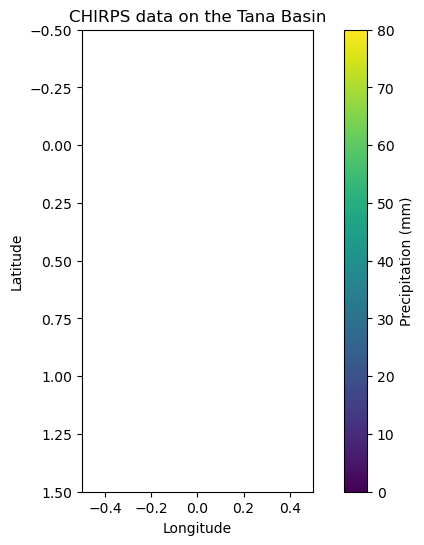

In [17]:
# Select one of the frames from clipped data
frame_index = 150
frame_data = clipped_data[frame_index]

# Define the range for the color scale
vmin = 0  # Minimum value
vmax = 80  # Maximum value

# Plot the figure for the chosen frame
plt.figure(figsize=(8, 6))
plt.imshow(frame_data, vmin=vmin, vmax=vmax)
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CHIRPS data on the Tana Basin')
# plt.grid(True)

plt.show()

In [18]:
clipped_values = clipped_data[~np.isnan(clipped_data)]
min_value = np.nanmin(clipped_values)
max_value = np.nanmax(clipped_values)
percentile_90 = np.nanpercentile(clipped_values, 99)
percentile_90

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
from matplotlib.animation import FuncAnimation
# Define a function to update the plot for each frame
def update(frame):
    plt.clf()  # Clear the current figure to update with the next frame
    plt.imshow(clipped_data[frame], vmin=min_value, vmax=percentile_90)
    plt.colorbar(label='Precipitation (mm)', ticks=[overall_min, percentile_90])  # Add colorbar with fixed scale
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clipped NetCDF Data (Time Step {frame})')

create_animation = False

if create_animation:
    
    fig, ax = plt.subplots(figsize=(8, 6))
    animation = FuncAnimation(fig, update, frames=len(clipped_data), interval=100)

    animation.save('clipped_data_animation.gif', writer='pillow')  # Use 'imagemagick' if 'pillow' does not work
    plt.show()